# PEAD - stock market response to events

PEAD: Post/Pre Earning Announcement Drift 



## 0. Import libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# import streamlit as st

In [2]:
import FinanceDataReader as fdr
import quantstats as qs

In [3]:
## custom libs

from korquanttools.pricevolume.loader import KRXPriceDM
from korquanttools.pricevolume.utils import DateUtil
from korquanttools.pricevolume.config import PathConfig

## 1. Import datasets

### Transaction volume & adjusted close data

- Import price-volume data module from KRX using custom lib `korquanttools`
- Import related datasets

In [4]:
# Global parameters

START = 20140101
END = 20220520

In [5]:
# Init data module
pricevolume = KRXPriceDM(START, END)
pricevolume.get_info()


        * DM name: KRX_pricevolume
        * DM description: Basic price-volume data imported from KRX website & NAVER finance. Has KOSPI, KOSDAQ, KONEX stocks.
        * birthday: 20211203
        * DM period: 19990101 ~ 
        * Available data: ['lv1', 'open', 'high', 'low', 'close', 'volume', 'dollarvolume', 'marketcap']
        


In [6]:
dollarvolume_df = pricevolume.get_data('dollarvolume')
dollarvolume_df = dollarvolume_df.astype(float)

In [7]:
holidays = dollarvolume_df.isnull().all(axis=1)
tradingdays = ~holidays

holidays = holidays.index[holidays]
tradingdays = tradingdays.index[tradingdays]

In [8]:
adjClose_df = pd.read_pickle(PathConfig.cache_path / f"temp_adjClose_{START}_{END}")
return_df = pd.read_pickle(PathConfig.cache_path / f"temp_return_{START}_{END}")

### Earnings calendar data

- Import earnings calendar data scraped from investing.com
    - Check data count / unique company count
    - Currently, only small part of calendar data is scraped

In [9]:
earnings_calendar_df = pd.read_pickle('earnings_calendar_20140101-20220530.pickle')

In [10]:
len(earnings_calendar_df)

243

In [11]:
len(earnings_calendar_df['sid'].unique())

138

## 2. Event analysis 

- Process earnings calendar data to lv2 format
- Mix earnings calendar data & dependent variable (dollarvolume, adj.close, etc...) to plot event response graph
    - Normalize response data (dollarvolume, adj.close, etc) by company because they vary a lot between one another. 


In [12]:
# Make calendar event df 
# 1: event day 0: nothing OR does not exist
earnings_calendar_df['is_announced'] = True
earnings_announcement_df = earnings_calendar_df.pivot(index='date', columns='sid', values='is_announced')
earnings_announcement_df = earnings_announcement_df.fillna(False)
earnings_announcement_df = earnings_announcement_df.reindex(index=dollarvolume_df.index, columns=dollarvolume_df.columns)

# Only use tradingdays data
dollarvolume_tradingdays_df = dollarvolume_df.loc[tradingdays, :]
earnings_announcement_tradingdays_df = earnings_announcement_df.loc[tradingdays, :]

### Normalization

In [13]:
NORMAL_WINDOW = 252 # Trading days in a year

In [14]:
dv_movingavg_tradingdays_df = dollarvolume_tradingdays_df.rolling(NORMAL_WINDOW).mean()
dv_movingstd_tradingdays_df = dollarvolume_tradingdays_df.rolling(NORMAL_WINDOW).std()

dv_stdnormal_tradingdays_df = (dollarvolume_tradingdays_df - dv_movingavg_tradingdays_df) / dv_movingstd_tradingdays_df

In [15]:
dv_stdnormal_tradingdays_df = dv_stdnormal_tradingdays_df.iloc[NORMAL_WINDOW:]
earnings_announcement_tradingdays_df = earnings_announcement_tradingdays_df.iloc[NORMAL_WINDOW:]

### Get near-event period response data

In [16]:
# Return dolloarvolume data back-and-forth for each event day.
# (5 days backward) _ _ _ _ _ EventDay _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ (20 days forward) 
# D-5 dollarvolume data       D-0                                    D+20 dollarvolume data

def event_by_sid(dollarvolume_df, earnings_announcement_df, d_minus=5, d_plus=20):
    assert dollarvolume_df.shape == earnings_announcement_df.shape
    assert (dollarvolume_df.index == earnings_announcement_df.index).all()
    assert (dollarvolume_df.columns == earnings_announcement_df.columns).all()

    sid_list = dollarvolume_df.columns
    date_list = np.array(dollarvolume_df.index)

    dollarvolume_2d = np.array(dollarvolume_df)
    event_2d = np.array(earnings_announcement_df)
    event_2d = np.where(event_2d == True, event_2d, False)
    
    dollarvolume_data = []
    for col_idx in range(event_2d.shape[1]):
        sid = sid_list[col_idx]

        dollar_col = dollarvolume_2d[:, col_idx]
        col = event_2d[:, col_idx]
        event_indices = np.where(col == True)[0]
        dates = date_list[event_indices]

        for event_idx, date in zip(event_indices, dates):
            start_idx = event_idx - d_minus
            if start_idx < 0:
                start_idx = 0
            
            end_idx = event_idx + d_plus
            if end_idx > len(col):
                end_idx = len(col) - 1
            
            event_period_data = dollar_col[start_idx:end_idx]
            dollarvolume_data.append({
                'sid': sid,
                'd_zero_date': date,
                'data': event_period_data, # TODO: Somewhere, data is becoming object!! 
            })
    
    return dollarvolume_data

In [17]:
dollarvolume_data = event_by_sid(dv_stdnormal_tradingdays_df, earnings_announcement_tradingdays_df)

In [18]:
dv_exploded_df = pd.DataFrame(dollarvolume_data).explode('data')
dv_exploded_df.reset_index(inplace=True, drop=True)
dv_exploded_df['data'] = dv_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

In [19]:
dv_exploded_df['d_date_num'] = dv_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()
dv_final_event_period_data = dv_exploded_df.groupby('d_date_num').mean()['data']

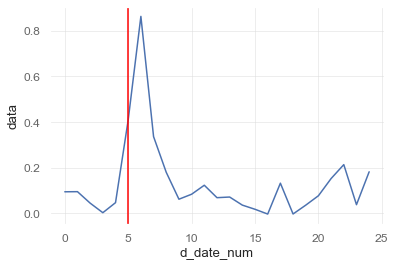

In [20]:
sns.lineplot(x=dv_final_event_period_data.index, y=dv_final_event_period_data)
plt.axvline(x=5, ymin=0, ymax=1, color='red')

## 3. Expansion - adj.close / return

In [21]:
NORMAL_WINDOW = 60 # 3 months = 1 quarter

In [22]:
# Only use tradingdays data
adjClose_tradingdays_df = adjClose_df.loc[tradingdays, :]
return_tradingdays_df = return_df.loc[tradingdays, :]


In [23]:
# adj Close
adjClose_movingavg_tradingdays_df = adjClose_tradingdays_df.rolling(NORMAL_WINDOW).mean()
adjClose_movingstd_tradingdays_df = adjClose_tradingdays_df.rolling(NORMAL_WINDOW).std()

adjClose_stdnormal_tradingdays_df = (adjClose_tradingdays_df - adjClose_movingavg_tradingdays_df) / adjClose_movingstd_tradingdays_df

# return
# return DOES NOT need normalization

In [24]:
adjClose_stdnormal_tradingdays_df = adjClose_stdnormal_tradingdays_df.iloc[NORMAL_WINDOW:]
return_tradingdays_df = return_tradingdays_df.iloc[NORMAL_WINDOW:]

earnings_announcement_tradingdays_df = earnings_announcement_df.loc[tradingdays, :]
earnings_announcement_tradingdays_df = earnings_announcement_tradingdays_df.iloc[NORMAL_WINDOW:]

In [25]:
adjClose_data = event_by_sid(adjClose_stdnormal_tradingdays_df, earnings_announcement_tradingdays_df)
return_data = event_by_sid(return_tradingdays_df, earnings_announcement_tradingdays_df)

In [26]:
adjClose_exploded_df = pd.DataFrame(adjClose_data).explode('data')
adjClose_exploded_df.reset_index(inplace=True, drop=True)
adjClose_exploded_df['data'] = adjClose_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

return_exploded_df = pd.DataFrame(return_data).explode('data')
return_exploded_df.reset_index(inplace=True, drop=True)
return_exploded_df['data'] = return_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

In [27]:
adjClose_exploded_df['d_date_num'] = adjClose_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()
adjClose_final_event_period_data = adjClose_exploded_df.groupby('d_date_num').mean()['data']

return_exploded_df['d_date_num'] = return_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()
return_final_event_period_data = return_exploded_df.groupby('d_date_num').mean()['data']

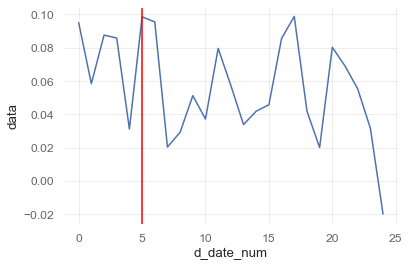

In [28]:
sns.lineplot(x=adjClose_final_event_period_data.index, y=adjClose_final_event_period_data)
plt.axvline(x=5, ymin=0, ymax=1, color='red')

We can observe that adj.Close declines after the event day

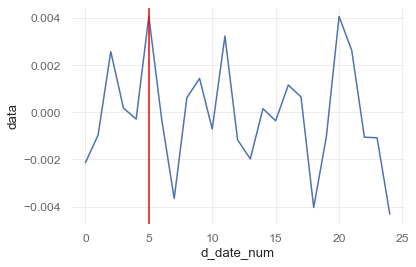

In [29]:
sns.lineplot(x=return_final_event_period_data.index, y=return_final_event_period_data)
plt.axvline(x=5, ymin=0, ymax=1, color='red')

# 4. Is there information leakage before announcement?

So far we have seen pre/post annoucnement change of dollarvolume, price, return. 

Now I will combine all these to test the hypothesis that there is information leakage in Korean stock market. 

The intuition is as follow:

- When we look at the dollarvolume change before the annoucement, we can see that there's a small drift before the announcement. 
- This could be due to many reasons like:
    - Risk-taking trades before the announcement. 
    - Information leakage before the announcement. 
        - i.e, insiders who already know the actual earning is higher/lower can make trades before the announcement to get near-risk-free return. 
- We can make a hypothesis out of this
    - If the insider knows that the earning is actual > forecast, he will buy(long) stocks. 
    - If the insider knows that the earning is actual < forecast, he will sell(short) stocks. 
- If the stock with information leakage is small capped and if the insider makes big enough trades to move the price:
    - Stock price will go up before actual > forecast is annoucned. 
    - Stock price will go down before actual < forecast is annoucned.
- Therefore, I will look at the "hit ratio" of cummulative return before the announcement to earnings announcement directions. 
    - If price goes up (= positive cumulative return) right before the announcement & earning is actual > forecast = HIT
    - If price goes down (= negative cumulative return) right before the announcement & earning is actual < forecast = MISS
- "Hit ratio" of each stock will be calculated. 
    - The data is 2014 ~ 2022 so 8y * 4q = 32 announcements per stock
    - If a certain stock has abnormally high "hit ratio", that stock is suspected of having information leakage. 
    

## 4-1 First, calculate pre-announcement cummulative return

This can be done by modifying already existing function just a little. 

In [30]:
# Return dolloarvolume data back-and-forth for each event day.
# (5 days backward) _ _ _ _ _ EventDay _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ (20 days forward) 
# D-5 dollarvolume data       D-0                                    D+20 dollarvolume data

def preannc_event_by_sid(return_df, earnings_announcement_df, d_minus=5, d_plus=20, preannc_days=None):
    assert return_df.shape == earnings_announcement_df.shape
    assert (return_df.index == earnings_announcement_df.index).all()
    assert (return_df.columns == earnings_announcement_df.columns).all()

    if preannc_days is None:
        preannc_days = d_minus - 1

    sid_list = return_df.columns
    date_list = np.array(return_df.index)

    return_2d = np.array(return_df).astype(float)
    event_2d = np.array(earnings_announcement_df)
    event_2d = np.where(event_2d == True, event_2d, False)
    
    return_data = []
    for col_idx in range(event_2d.shape[1]):
        sid = sid_list[col_idx]

        dollar_col = return_2d[:, col_idx]
        col = event_2d[:, col_idx]
        event_indices = np.where(col == True)[0]
        dates = date_list[event_indices]

        for event_idx, date in zip(event_indices, dates):
            start_idx = event_idx - d_minus
            if start_idx < 0:
                start_idx = 0
            
            end_idx = event_idx + d_plus
            if end_idx > len(col):
                end_idx = len(col) - 1
            
            event_period_data = dollar_col[start_idx:end_idx]
            preannc_cumreturn = event_period_data[:preannc_days].sum()

            return_data.append({
                'sid': sid,
                'd_zero_date': date,
                'data': event_period_data, # TODO: Somewhere, data is becoming object!! 
                'preannc': preannc_cumreturn,
            })
    
    return return_data

In [31]:
# Only use tradingdays data
return_tradingdays_df = return_df.loc[tradingdays, :]
earnings_announcement_tradingdays_df = earnings_announcement_df.loc[tradingdays, :]

In [35]:
return_data = preannc_event_by_sid(return_tradingdays_df, earnings_announcement_tradingdays_df)

In [36]:
return_exploded_df = pd.DataFrame(return_data).explode('data')
return_exploded_df.reset_index(inplace=True, drop=True)
return_exploded_df['data'] = return_exploded_df['data'].astype(float) # TODO: Somewhere before data has become object!!

In [38]:
return_exploded_df['d_date_num'] = return_exploded_df.groupby(['sid', 'd_zero_date']).cumcount()

In [40]:
return_exploded_df['is_positive_preannc'] = (return_exploded_df['preannc'] >= 0)

In [42]:
return_exploded_df.dropna(inplace=True)

In [45]:
len(return_exploded_df[return_exploded_df['is_positive_preannc'] == True])

2625

In [46]:
len(return_exploded_df[return_exploded_df['is_positive_preannc'] != True])

2450

In [51]:
return_exploded_df[
    (return_exploded_df['d_date_num'] == 5) &
    (return_exploded_df['data'] > 0) &
    (return_exploded_df['is_positive_preannc'] == True) 
]

,sid,d_zero_date,data,preannc,d_date_num,is_positive_preannc
5,000100,2015-02-25,0.011564,0.000108,5,True
55,000120,2014-02-25,0.035714,0.056057,5,True
205,000660,2015-01-28,0.001017,0.025830,5,True
255,000660,2016-04-26,0.060000,0.011019,5,True
280,000660,2017-01-26,0.030948,0.055599,5,True
305,000660,2019-01-24,0.055389,0.028102,5,True
455,000810,2016-02-18,0.039539,0.004792,5,True
480,000815,2017-02-15,0.002646,0.000184,5,True
505,000990,2014-02-14,0.001304,0.048131,5,True
555,001045,2021-01-04,0.008818,0.076285,5,True


In [54]:
positive_bet = return_exploded_df[
    (return_exploded_df['d_date_num'].isin([5, 6])) &
    (return_exploded_df['data'] > 0) &
    (return_exploded_df['is_positive_preannc'] == True) 
]
positive_bet

,sid,d_zero_date,data,preannc,d_date_num,is_positive_preannc
5,000100,2015-02-25,0.011564,0.000108,5,True
55,000120,2014-02-25,0.035714,0.056057,5,True
156,000490,2022-01-21,0.004255,0.044157,6,True
205,000660,2015-01-28,0.001017,0.025830,5,True
255,000660,2016-04-26,0.060000,0.011019,5,True
...,...,...,...,...,...,...
4881,028260,2020-01-22,0.044643,0.046577,6,True
4980,219420,2018-01-08,0.070236,0.074587,5,True
4981,219420,2018-01-08,0.057897,0.074587,6,True
5005,207940,2021-01-26,0.015190,0.007640,5,True


In [55]:
negative_bet = return_exploded_df[
    (return_exploded_df['d_date_num'].isin([5, 6])) &
    (return_exploded_df['data'] < 0) &
    (return_exploded_df['is_positive_preannc'] == False) 
]
negative_bet

,sid,d_zero_date,data,preannc,d_date_num,is_positive_preannc
80,000270,2015-01-23,-0.018924,-0.042201,5,False
81,000270,2015-01-23,-0.056853,-0.042201,6,False
106,000270,2016-01-27,-0.024691,-0.017466,6,False
330,000660,2020-01-31,-0.005319,-0.013354,5,False
355,000660,2021-01-29,-0.004065,-0.020550,5,False
...,...,...,...,...,...,...
4530,096770,2016-02-03,-0.011278,-0.027419,5,False
4555,096770,2016-04-22,-0.021538,-0.103883,5,False
4631,097950,2014-02-27,-0.001818,-0.007327,6,False
5030,207940,2022-01-24,-0.008559,-0.040041,5,False


In [58]:
set(positive_bet['sid'].unique()) & set(negative_bet['sid'].unique())

{'000660',
 '000990',
 '001440',
 '005385',
 '005935',
 '005950',
 '006400',
 '010950',
 '011200',
 '012330',
 '017670',
 '018880',
 '032830',
 '033780',
 '034020',
 '035420',
 '036570',
 '050890',
 '055550',
 '066575',
 '086790',
 '207940'}

Most of them are large cap stocks. 

Pretty unlikely they are leaking insider information for petty investment return. 

In [ ]:

return_final_event_period_data = return_exploded_df.groupby('d_date_num').mean()['data']